In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

# Импорт таблиц

In [3]:
customers = pd.read_csv('D:/Datasets/hackathon/customers.csv')
geolocation = pd.read_csv('D:/Datasets/hackathon/geolocation.csv')
order_payments = pd.read_csv('D:/Datasets/hackathon/order_payments.csv')
order_reviews = pd.read_csv('D:/Datasets/hackathon/order_reviews.csv')
orders = pd.read_csv('D:/Datasets/hackathon/orders.csv')
orders_items = pd.read_csv('D:/Datasets/hackathon/orders_items.csv')
product_category_name_translation = pd.read_csv('D:/Datasets/hackathon/product_category_name_translation.csv')
products = pd.read_csv('D:/Datasets/hackathon/products.csv')
sellers = pd.read_csv('D:/Datasets/hackathon/sellers.csv')

<ipython-input-3-bda70da7bfa2>:6: DtypeWarning: Columns (1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_items = pd.read_csv('orders_items.csv')


### Инфа по таблицам

In [ ]:
# print(customers.head())
# print(customers.info())
# print(customers.isnull().sum())

# print(geolocation.head())
# print(geolocation.info())
# print(geolocation.isnull().sum)

# print(order_payments.head())
# print(order_payments.info())
# print(order_payments.isnull().sum)

# print(order_reviews.head())
# print(order_reviews.info())
# print(order_reviews.isnull().sum())

# print(orders.head())
# print(orders.info())
# print(orders.isnull().sum())


# print(orders_items.head())
# print(orders_items.info())
# print(orders_items.isnull().sum())

# print(product_category_name_translation.head())
# print(product_category_name_translation.info())
# print(product_category_name_translation.isnull().sum())

# print(products.head())
# print(products.info())
# print(products.isnull().sum())

# print(sellers.head())
# print(sellers.info())
# print(sellers.isnull().sum())

## Первичная работа с данными

### Заказ может состоять из нескольких товаров одного продавца

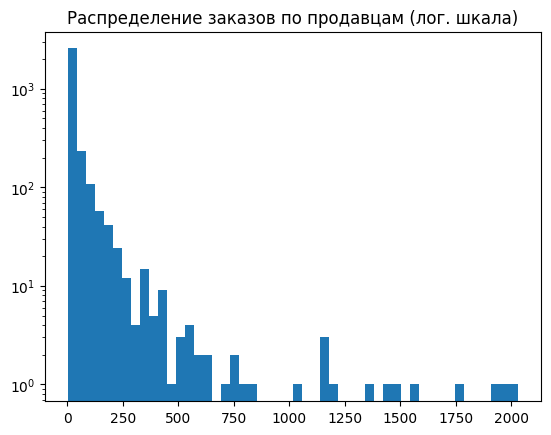

In [6]:
new_orders = pd.merge(orders, orders_items, on='order_id', how='inner')

separation_seller_by_products = new_orders.groupby(['seller_id'])['order_id'].count()

plt.hist(separation_seller_by_products, bins=50, log=True)
plt.title('Распределение заказов по продавцам (лог. шкала)')
plt.show()

### Количество проданных товаров

### График продаж "топового" магазина

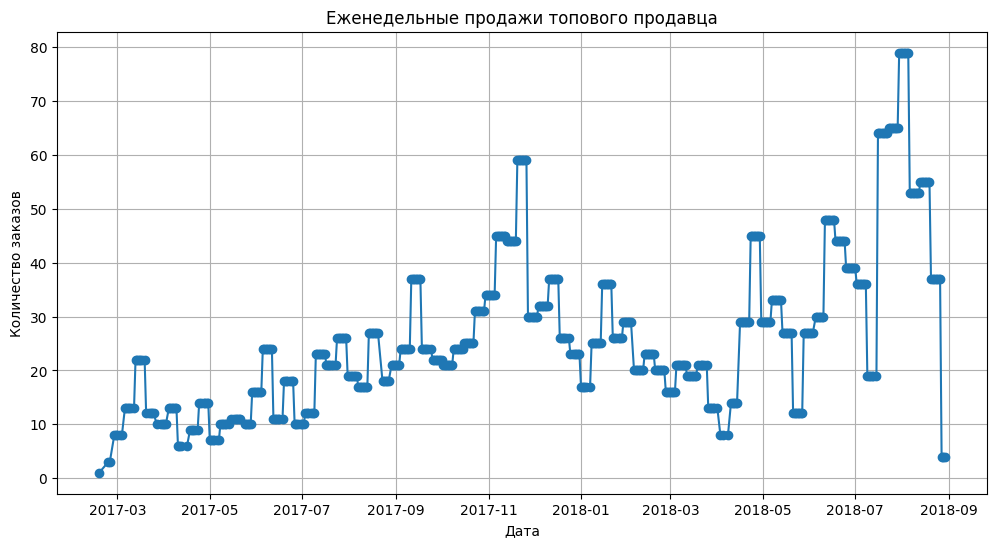

In [5]:
result = (
    pd.merge(orders, orders_items, on='order_id')
    .query("seller_id == '6560211a19b47992c3666cc44a7e94c0'")
    .assign(
        order_date=lambda x: pd.to_datetime(x['order_purchase_timestamp']).dt.date,
        week_id=lambda x: pd.to_datetime(x['order_purchase_timestamp']).dt.strftime('%Y-%W'),
        weekly_sales=lambda x: x.groupby('week_id')['order_id'].transform('count')
    )
    [['order_date', 'week_id', 'weekly_sales']]
    .sort_values('order_date')
    .drop_duplicates()
    .reset_index(drop=True)
)

plt.figure(figsize=(12, 6))
plt.plot(result['order_date'], result['weekly_sales'], marker='o')
plt.title('Еженедельные продажи топового продавца')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

### Количество проданных категорий товаров от лидера продаж

Продажи по категориям:
product_category_name_english  order_count  total_revenue  avg_price
                watches_gifts         1628      100913.00  61.985872
     fashion_bags_accessories          340       18076.83  53.167147
                        audio           32        2716.00  84.875000
                    perfumery           13         369.00  28.384615
        computers_accessories           12         600.00  50.000000
               sports_leisure            7         531.00  75.857143
    construction_tools_safety            1          99.00  99.000000


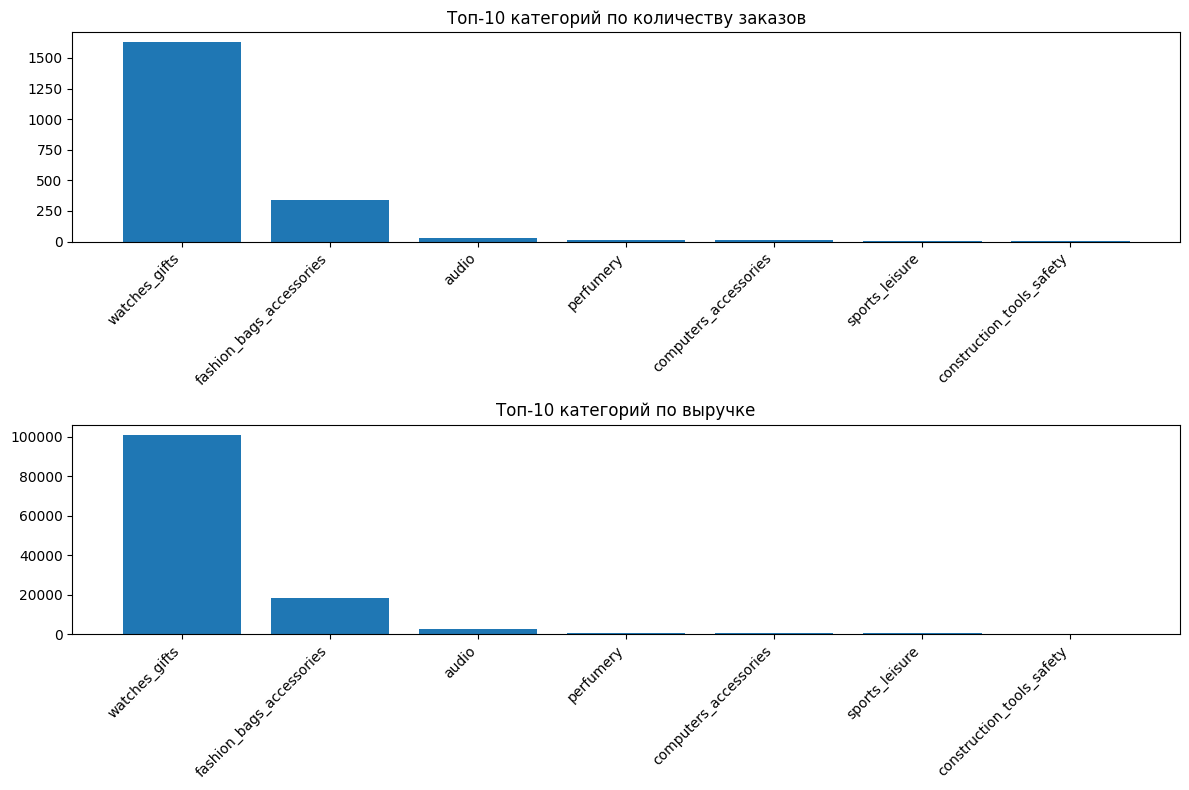


Общая статистика продавца:
Всего заказов: 1854
Всего товаров: 2033
Уникальных категорий: 7
Средний чек: 66.51


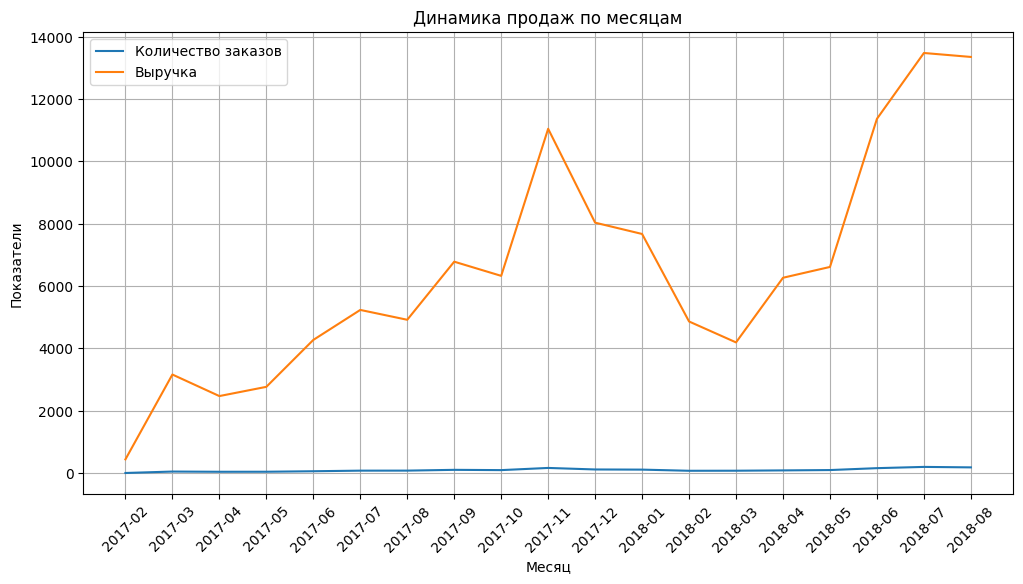

In [7]:
best_seller_sales = (
    pd.merge(orders, orders_items, on='order_id')
    .merge(products, on='product_id')
    .merge(product_category_name_translation, on='product_category_name')
    .query("seller_id == '6560211a19b47992c3666cc44a7e94c0'")
)

category_sales = (
    best_seller_sales
    .groupby('product_category_name_english', as_index=False)
    .agg(
        order_count=('order_id', 'count'),
        total_revenue=('price', 'sum'),
        avg_price=('price', 'mean')
    )
    .sort_values('order_count', ascending=False)
)

print("Продажи по категориям:")
print(category_sales.to_string(index=False))

plt.figure(figsize=(12, 8))
top_categories = category_sales.head(10)

plt.subplot(2, 1, 1)
plt.bar(top_categories['product_category_name_english'], top_categories['order_count'])
plt.title('Топ-10 категорий по количеству заказов')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
plt.bar(top_categories['product_category_name_english'], top_categories['total_revenue'])
plt.title('Топ-10 категорий по выручке')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nОбщая статистика продавца:")
print(f"Всего заказов: {best_seller_sales['order_id'].nunique()}")
print(f"Всего товаров: {len(best_seller_sales)}")
print(f"Уникальных категорий: {best_seller_sales['product_category_name_english'].nunique()}")
print(f"Средний чек: {best_seller_sales.groupby('order_id')['price'].sum().mean():.2f}")

best_seller_sales['month'] = pd.to_datetime(best_seller_sales['order_purchase_timestamp']).dt.to_period('M')
monthly_sales = best_seller_sales.groupby('month').agg(
    orders=('order_id', 'nunique'),
    revenue=('price', 'sum')
).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['month'].astype(str), monthly_sales['orders'], label='Количество заказов')
plt.plot(monthly_sales['month'].astype(str), monthly_sales['revenue'], label='Выручка')
plt.title('Динамика продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Показатели')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Проданные категории товаров всеми магазинами

Количество проданных товаров по категориям:
                                         total_orders  unique_products  total_revenue
product_category_name_english                                                        
security_and_services                               2                2         283.29
fashion_childrens_clothes                           8                5         569.85
la_cuisine                                         14               10        2054.99
cds_dvds_musicals                                  14                1         730.00
arts_and_craftmanship                              24               19        1814.01
fashion_sport                                      30               19        2119.51
home_comfort_2                                     30                5         760.27
flowers                                            33               14        1110.04
music                                              38               27        6034.35
furniture_

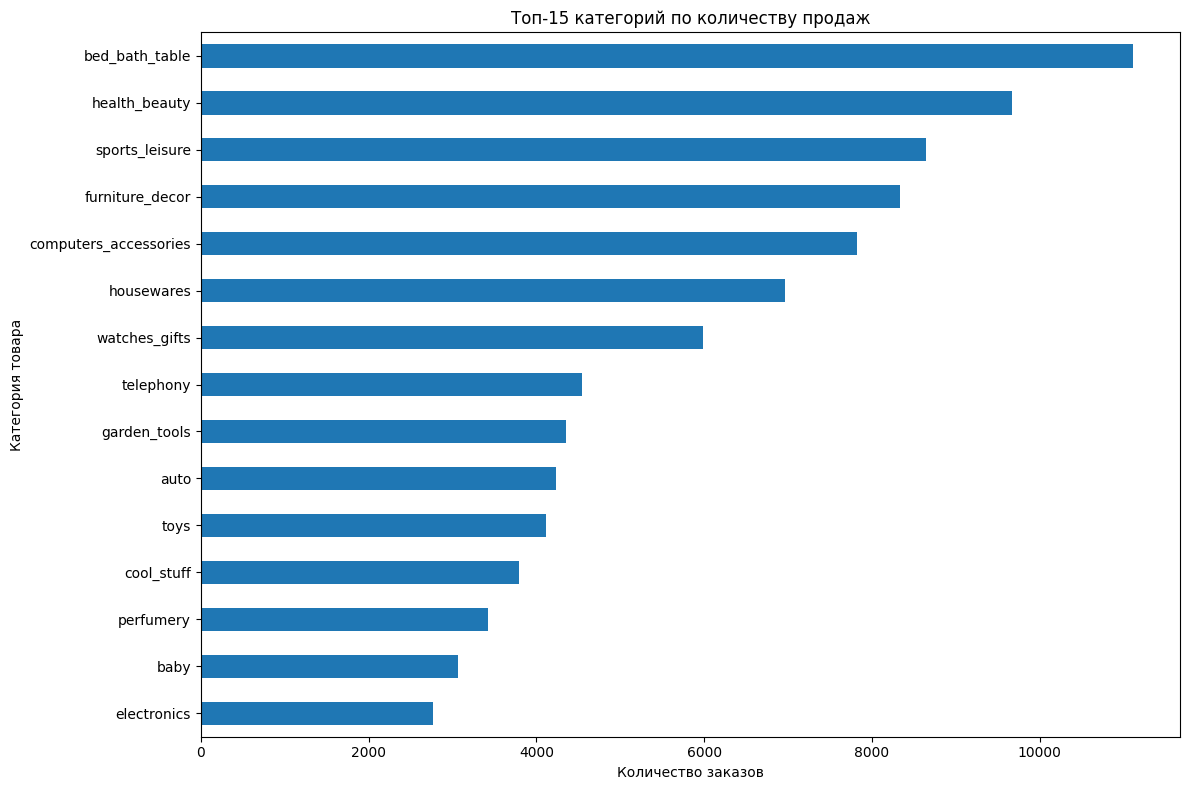


Общая статистика:
Всего категорий: 71
Среднее количество заказов на категорию: 1563.7
Медианное количество заказов: 281.0

Топ-5 категорий по выручке:
                               total_revenue
product_category_name_english               
health_beauty                     1258681.34
watches_gifts                     1205005.68
bed_bath_table                    1036988.68
sports_leisure                     988048.97
computers_accessories              911954.32


In [9]:
sales_data = (
    orders.merge(orders_items, on='order_id')
          .merge(products, on='product_id')
          .merge(product_category_name_translation,
                on='product_category_name')
)

category_sales = (
    sales_data.groupby('product_category_name_english')
              .agg(
                  total_orders=('order_id', 'count'),
                  unique_products=('product_id', 'nunique'),
                  total_revenue=('price', 'sum')
              )
              .sort_values('total_orders')
)

print("Количество проданных товаров по категориям:")
print(category_sales.to_string())

# Топ-15 категорий
top_categories = category_sales.tail(15)

plt.figure(figsize=(12, 8))
top_categories['total_orders'].plot(kind='barh')
plt.title('Топ-15 категорий по количеству продаж')
plt.xlabel('Количество заказов')
plt.ylabel('Категория товара')
plt.tight_layout()
plt.show()

print("\nОбщая статистика:")
print(f"Всего категорий: {len(category_sales)}")
print(f"Среднее количество заказов на категорию: {category_sales['total_orders'].mean():.1f}")
print(f"Медианное количество заказов: {category_sales['total_orders'].median()}")
print(f"\nТоп-5 категорий по выручке:")
print(category_sales.nlargest(5, 'total_revenue')[['total_revenue']])

### Количество проданного одного товара всеми продавцами

Всего продавцов в категории bed_bath_table: 196

Топ-5 продавцов:
                                  total_orders  total_items  total_revenue
seller_id                                                                 
4a3ca9315b744ce9f8e9374361493884          1459         1572      165219.25
da8622b14eb17ae2831f4ac5b9dab84a          1074         1277      152307.80
d2374cbcbb3ca4ab1086534108cc3ab7           497          597       20266.32
1835b56ce799e6a4dc4eddc053f04066           418          553       33059.26
1900267e848ceeba8fa32d80c1a5f5a8           405          519       24128.63


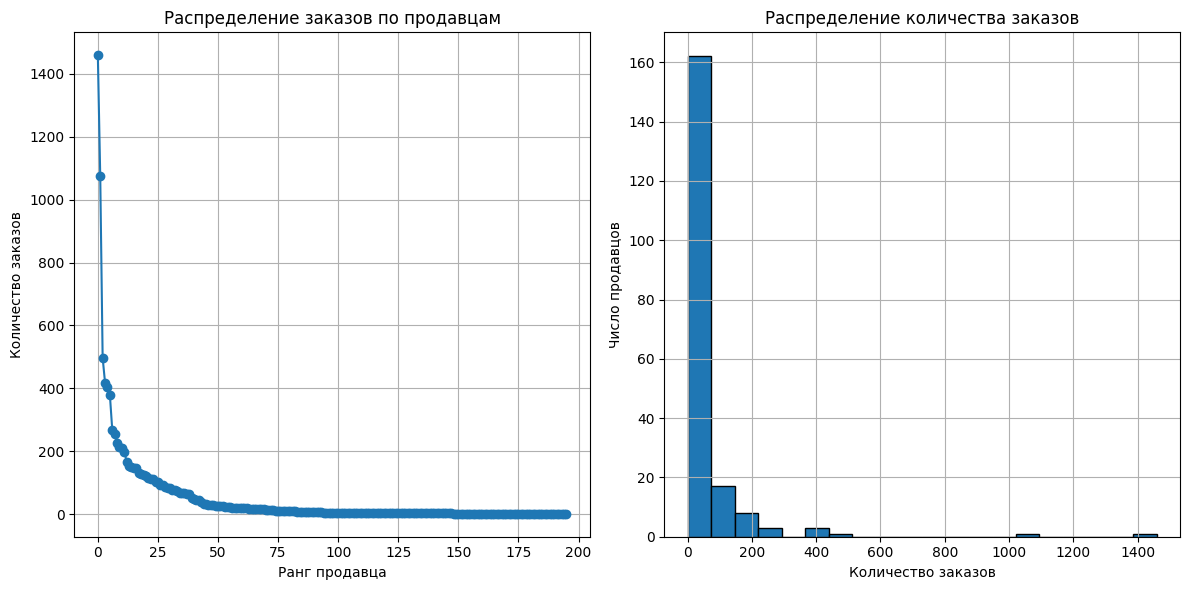


Статистика по категории bed_bath_table:
Среднее количество заказов на продавца: 49.1
Медианное количество заказов: 5.0
Общая выручка категории: R$1,036,988.68


In [10]:
merged_data = (
    orders.merge(orders_items, on='order_id')
          .merge(products, on='product_id')
          .merge(product_category_name_translation, on='product_category_name')
)

bed_bath_sellers = (
    merged_data[merged_data['product_category_name_english'] == 'bed_bath_table']
    .groupby('seller_id')
    .agg(
        total_orders=('order_id', 'nunique'),
        total_items=('order_id', 'count'),
        total_revenue=('price', 'sum')
    )
    .sort_values('total_orders', ascending=False)
)

print(f"Всего продавцов в категории bed_bath_table: {len(bed_bath_sellers)}")
print("\nТоп-5 продавцов:")
print(bed_bath_sellers.head(5).to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(bed_bath_sellers)), bed_bath_sellers['total_orders'], 'o-')
plt.title('Распределение заказов по продавцам')
plt.xlabel('Ранг продавца')
plt.ylabel('Количество заказов')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(bed_bath_sellers['total_orders'], bins=20, edgecolor='black')
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Число продавцов')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nСтатистика по категории bed_bath_table:")
print(f"Среднее количество заказов на продавца: {bed_bath_sellers['total_orders'].mean():.1f}")
print(f"Медианное количество заказов: {bed_bath_sellers['total_orders'].median()}")
print(f"Общая выручка категории: R${bed_bath_sellers['total_revenue'].sum():,.2f}")

### Средняя оценка

Анализ продавцов в категории 'bed_bath_table':
                       seller_id  total_orders  total_items  avg_review_score  review_count
1cd9e0cc1839d55516843def5600816d             5            5          5.000000             5
0bae85eb84b9fb3bd773911e89288d54             3            3          5.000000             3
11fb6f6d341adbe19e81733701704635             3            3          5.000000             3
2075d8cd4dd63ff12df0749a5866bb06             3            3          5.000000             3
709e16e2b25c7474d980076c6bfc4806             3            6          5.000000             6
83c465a786b06574376909b35ef6752a             3            3          5.000000             3
ac3508719a1d8f5b7614b798f70af136             3            3          5.000000             3
1cbdc7cf130a41fd13a3c2a7d2fcfda7             2            2          5.000000             2
33cbda8716511e27e556dff9d8418bf2             2            2          5.000000             2
6481e96574816ead57975da2c0f6d80d 

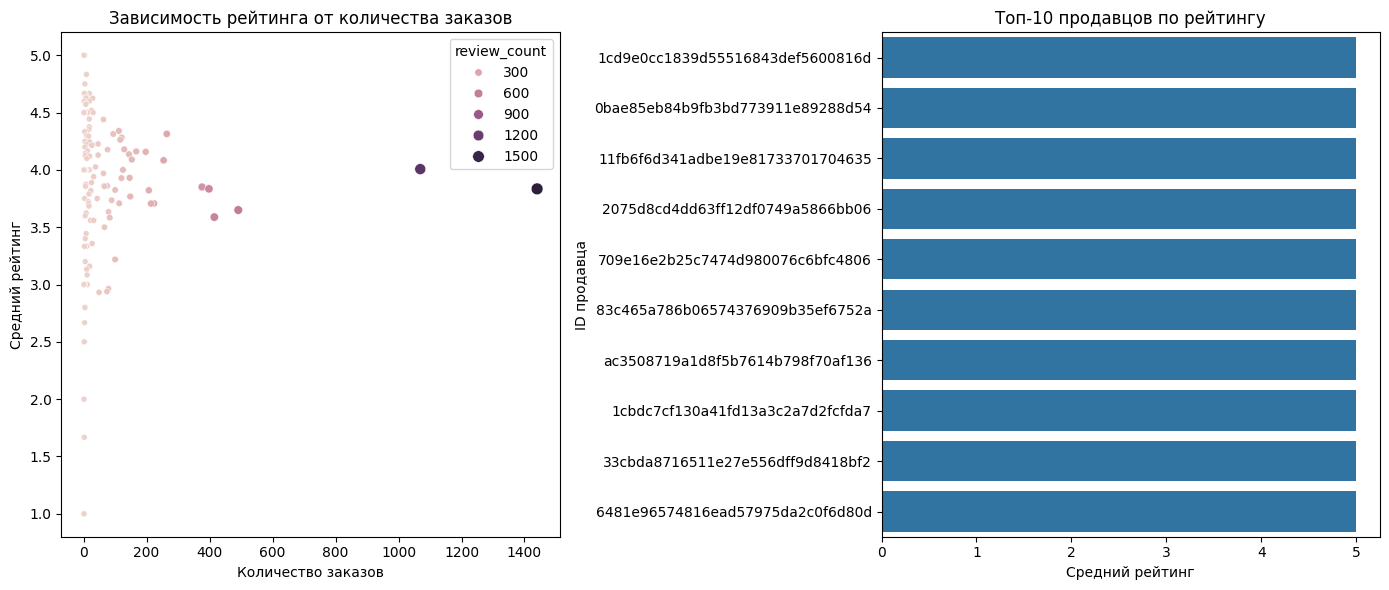

In [11]:
merged_data = (
    orders.merge(orders_items, on='order_id')
          .merge(products, on='product_id')
          .merge(product_category_name_translation, on='product_category_name')
          .merge(order_reviews, on='order_id')
)

bed_bath_analysis = (
    merged_data[merged_data['product_category_name_english'] == 'bed_bath_table']
    .groupby('seller_id')
    .agg(
        total_orders=('order_id', 'nunique'),
        total_items=('order_id', 'count'),
        avg_review_score=('review_score', 'mean'),
        review_count=('review_score', 'count')
    )
    .sort_values(['avg_review_score', 'total_orders'], ascending=[False, False])
    .reset_index()
)

print("Анализ продавцов в категории 'bed_bath_table':")
print(bed_bath_analysis.to_string(index=False))

print("\nОбщая статистика по категории:")
print(f"Всего продавцов: {len(bed_bath_analysis)}")
print(f"Средний рейтинг: {bed_bath_analysis['avg_review_score'].mean():.2f}")
print(f"Медианное количество заказов: {bed_bath_analysis['total_orders'].median()}")
print(f"Продавец с самым высоким рейтингом: {bed_bath_analysis.loc[bed_bath_analysis['avg_review_score'].idxmax(), 'seller_id']} ({bed_bath_analysis['avg_review_score'].max():.2f})")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=bed_bath_analysis, x='total_orders', y='avg_review_score', size='review_count', hue='review_count')
plt.title('Зависимость рейтинга от количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Средний рейтинг')

# Топ-10 продавцов по рейтингу
top_sellers = bed_bath_analysis.nlargest(10, 'avg_review_score')
plt.subplot(1, 2, 2)
sns.barplot(data=top_sellers, x='avg_review_score', y='seller_id')
plt.title('Топ-10 продавцов по рейтингу')
plt.xlabel('Средний рейтинг')
plt.ylabel('ID продавца')

plt.tight_layout()
plt.show()

# Основной датасет (поиск корреляций)

Анализ продавцов в категории bed_bath_table:
                                  total_orders_per_seller  total_items_sold_by_category  avg_review_score  number_of_orders
seller_id                                                                                                                  
4a3ca9315b744ce9f8e9374361493884                     1949                          1542          3.862516          1.121920
da8622b14eb17ae2831f4ac5b9dab84a                     1565                          1292          4.011610          1.164861
d2374cbcbb3ca4ab1086534108cc3ab7                      639                           604          3.658940          1.192053
1835b56ce799e6a4dc4eddc053f04066                      547                           542          3.614391          1.110701
1900267e848ceeba8fa32d80c1a5f5a8                      518                           508          3.858268          1.218504
8160255418d5aaa7dbdc9f4c64ebda44                      422                           416

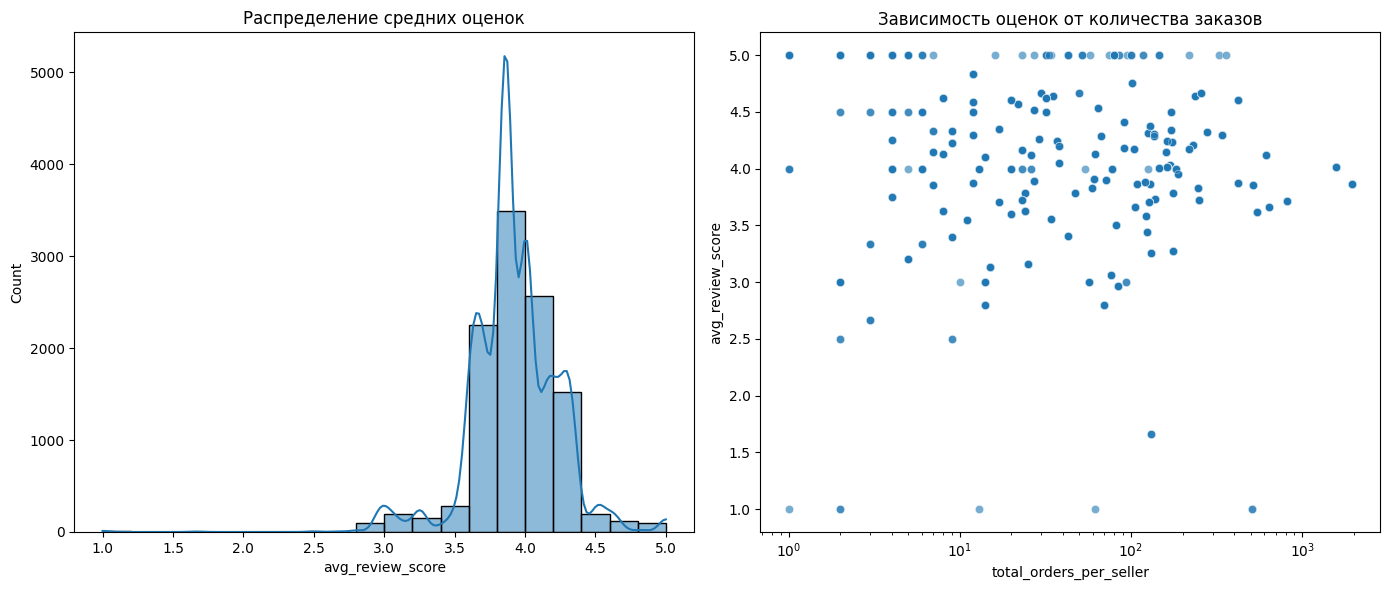

In [12]:
dataset = (
    orders.merge(orders_items, on='order_id')
          .merge(products, on='product_id')
          .merge(product_category_name_translation, on='product_category_name')
          .merge(order_reviews, on='order_id')
          .merge(customers, on='customer_id')
)

dataset = dataset[dataset['order_status'] == 'delivered'].copy()

dataset['order_purchase_month'] = pd.to_datetime(dataset['order_purchase_timestamp']).dt.to_period('M')

for col in dataset.select_dtypes(include=['float64', 'int64']).columns:
    dataset[col] = pd.to_numeric(dataset[col], downcast='float' if 'float' in str(dataset[col].dtype) else 'integer')

aggregations = {
    'total_orders_per_seller': dataset.groupby('seller_id')['order_id'].count(),
    'total_items_sold_by_category': dataset.groupby(['product_category_name_english', 'seller_id'])['order_id'].count(),
    'avg_review_score': dataset.groupby(['product_category_name_english', 'seller_id'])['review_score'].mean(),
    'customer_buying_products_overall': dataset.groupby('customer_unique_id')['product_category_name_english'].count(),
    'total_items_bought': dataset.groupby('customer_unique_id')['order_item_id'].count(),
    'number_of_orders': dataset.groupby('customer_unique_id')['order_id'].nunique(),
    'customer_buying_products_by_seller': dataset.groupby(['customer_unique_id', 'product_category_name_english'])['seller_id'].count(),
    'monthly_orders': dataset.groupby(['customer_unique_id', 'order_purchase_month'])['order_id'].count()
}

for new_col_name, agg_series in aggregations.items():
    agg_df = agg_series.reset_index()
    agg_df.rename(columns={agg_series.name: new_col_name}, inplace=True)  # Переименование столбца
    dataset = dataset.merge(agg_df, how='left', on=agg_df.columns[:-1].tolist())  # Объединение по всем столбцам, кроме последнего

bed_bath_stats = (
    dataset[dataset['product_category_name_english'] == 'bed_bath_table']
    .groupby('seller_id')
    .agg({
        'total_orders_per_seller': 'first',
        'total_items_sold_by_category': 'first',
        'avg_review_score': 'mean',
        'number_of_orders': 'mean'
    })
    .sort_values('total_items_sold_by_category', ascending=False)
)

print("Анализ продавцов в категории bed_bath_table:")
print(bed_bath_stats.head(10).to_string())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=dataset[dataset['product_category_name_english'] == 'bed_bath_table'],
             x='avg_review_score', bins=20, kde=True)
plt.title('Распределение средних оценок')

plt.subplot(1, 2, 2)
sns.scatterplot(data=dataset[dataset['product_category_name_english'] == 'bed_bath_table'],
                x='total_orders_per_seller', y='avg_review_score', alpha=0.6)
plt.title('Зависимость оценок от количества заказов')
plt.xscale('log')

plt.tight_layout()
plt.show()


In [13]:
dataset['order_purchase_timestamp'] = pd.to_datetime(dataset['order_purchase_timestamp'])

dataset['order_purchase_month'] = dataset['order_purchase_timestamp'].dt.to_period('M')

dataset = dataset.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

dataset['days_since_previous'] = dataset.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

max_days_since_previous = (
    dataset
    .groupby('customer_unique_id')
    .agg(
        total_orders=('order_id', 'count'),
        max_period=('days_since_previous', 'max')
    )
    .fillna(0)
)

max_days_since_previous = max_days_since_previous.sort_values(by='max_period', ascending=False)

print(max_days_since_previous)


                                  total_orders  max_period
customer_unique_id                                        
ccafc1c3f270410521c3c6f3b249870f             2       608.0
d8f3c4f441a9b59a29f977df16724f38             4       582.0
94e5ea5a8c1bf546db2739673060c43f             2       580.0
87b3f231705783eb2217e25851c0a45d             2       572.0
4e23e1826902ec9f208e8cc61329b494             2       524.0
...                                        ...         ...
55fce1ba5ed536b6b60c5b799815f45c             1         0.0
55fcb2a02e244d1f0de2c490cb9f5a18             1         0.0
55fc3a9e868992d2d339316d0800ecd2             4         0.0
55fb9192213bf782857b13d56eb0ec80             1         0.0
56030b824757ac1ff1e598db51cca04f             1         0.0

[91482 rows x 2 columns]


In [14]:
dataset['order_purchase_month'] = pd.to_datetime(dataset['order_purchase_timestamp']).dt.to_period('M')

monthly_orders = (
    dataset
    .groupby(['customer_unique_id', 'order_purchase_month'])['order_id']
    .count()
    .reset_index(name='orders_count')
)

print(monthly_orders)

                     customer_unique_id order_purchase_month  orders_count
0      0000366f3b9a7992bf8c76cfdf3221e2              2018-05             1
1      0000b849f77a49e4a4ce2b2a4ca5be3f              2018-05             1
2      0000f46a3911fa3c0805444483337064              2017-03             1
3      0000f6ccb0745a6a4b88665a16c9f078              2017-10             1
4      0004aac84e0df4da2b147fca70cf8255              2017-11             1
...                                 ...                  ...           ...
93245  fffcf5a5ff07b0908bd4e2dbc735a684              2017-06             2
93246  fffea47cd6d3cc0a88bd621562a9d061              2017-12             1
93247  ffff371b4d645b6ecea244b27531430a              2017-02             1
93248  ffff5962728ec6157033ef9805bacc48              2018-05             1
93249  ffffd2657e2aad2907e67c3e9daecbeb              2017-05             1

[93250 rows x 3 columns]


In [ ]:
# Расчёт количества проданных товаров по продавцу

data = dataset.groupby('customer_unique_id')['order_id'].count()

filtered = data[data > 2]

print(filtered)


customer_unique_id
000fbf0473c10fc1ab6f8d2d286ce20c    4
004288347e5e88a27ded2bb23747066c    4
0064a1b5f5cddd047c987b988a90c8c1    4
0085139b503668b3addcfe826d91be8d    3
0096c18412349537abc45e350581cbbc    4
                                   ..
ff9ff869636c26565ded16038be5fa7d    3
ffbb6557e45f7158781514f0efddb0d5    4
ffe780a8995715d9560ca10f3351710f    3
fff22793223fe80c97a8fd02ac5c6295    3
fff5eb4918b2bf4b2da476788d42051c    6
Name: order_id, Length: 4074, dtype: int64


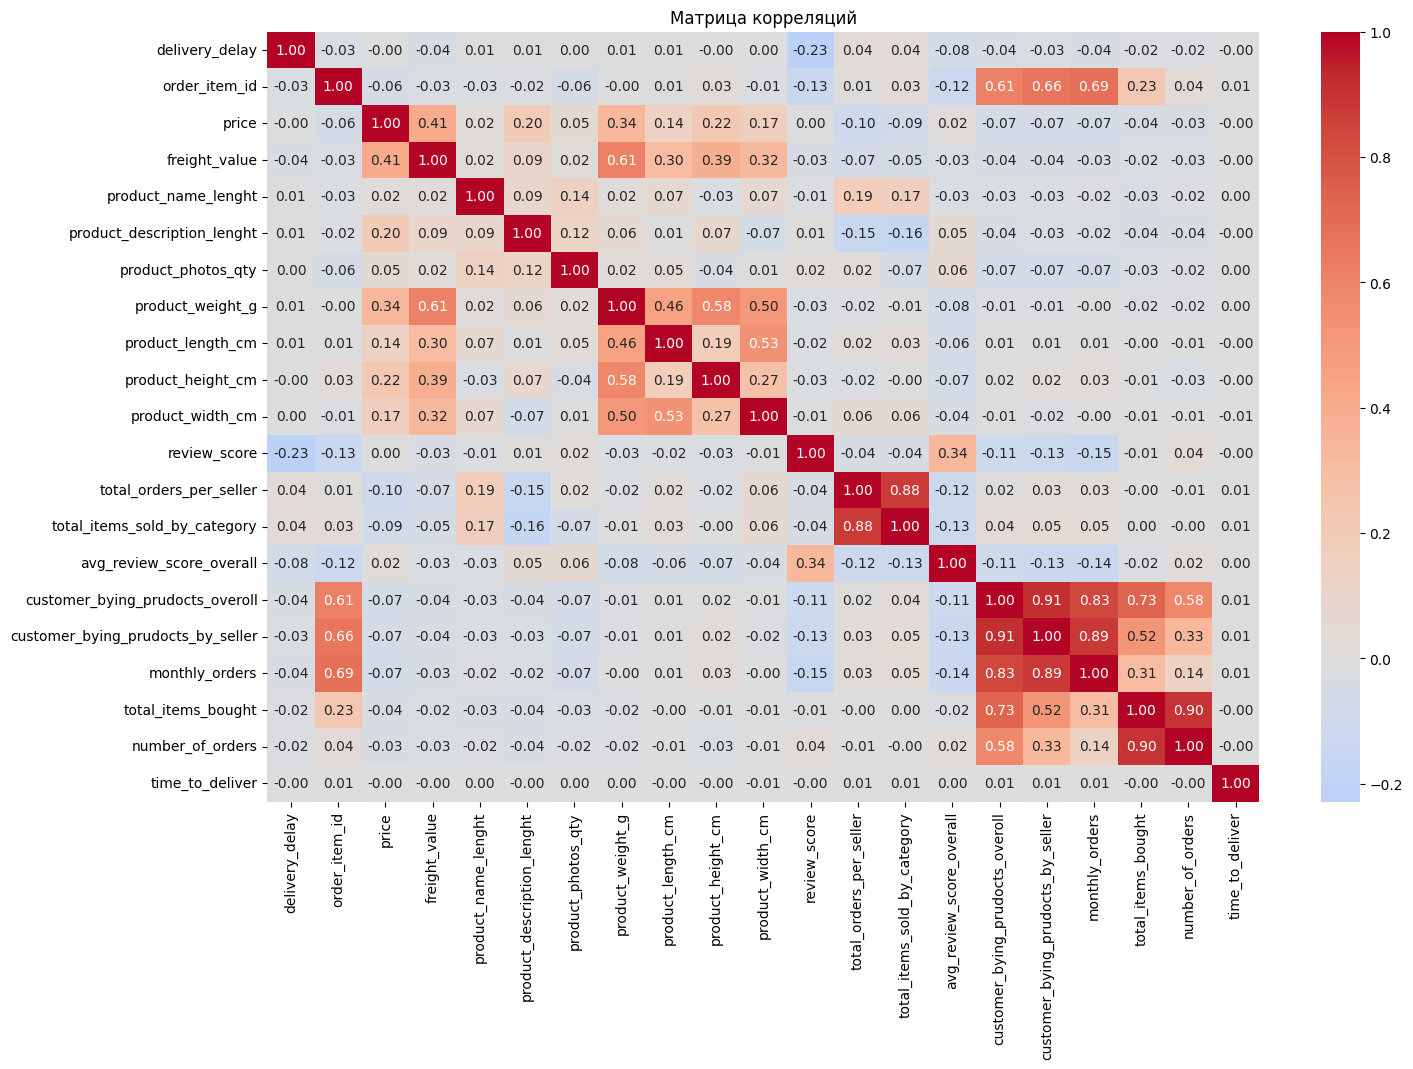

In [ ]:
#dataset = dataset.drop(['Unnamed: 0_x', 'price.1', 'freight_value.1', 'customer_zip_code_prefix', 'Unnamed: 0_y', 'Unnamed: 0'], axis=1)

corr_matrix = dataset.corr(numeric_only = True)

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляций")
plt.show()

Проверить: Покупал ли покупатель одну категорию товаров у разных продавцов

In [15]:
cust_to_prod_cat = dataset.groupby(['customer_unique_id', 'product_category_name_english'])['seller_id'].count()

kek = dataset.groupby('customer_unique_id')['product_category_name_english'].count()

cust_to_prod_cat_f = cust_to_prod_cat[cust_to_prod_cat > 3]

print(cust_to_prod_cat_f)

customer_unique_id                product_category_name_english
0064a1b5f5cddd047c987b988a90c8c1  garden_tools                     4
0096c18412349537abc45e350581cbbc  housewares                       4
0097fca0db567f5ca79509b7b4fc1c2d  furniture_decor                  6
00ae50eb5e1d2514f694dee1dcbbd5ae  furniture_decor                  4
0178b244a5c281fb2ade54038dd4b161  bed_bath_table                   4
                                                                  ..
fe3b584c005a5939657032dd355bdc21  bed_bath_table                   4
fe86d9409d83a3c561ce16e64d2d55e6  auto                             6
ff7f36f6ba0f1126bb95b635322cf9d2  health_beauty                    6
ffbb6557e45f7158781514f0efddb0d5  sports_leisure                   4
fff5eb4918b2bf4b2da476788d42051c  signaling_and_security           6
Name: seller_id, Length: 1064, dtype: int64


## Анализ вторичных признаков

### Влияние рейтинга магазина на продажи

### Влияние задрежки доставки на продажи

In [18]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], errors='coerce')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], errors='coerce')
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

orders['delivery_delay'] = (
    orders['order_delivered_customer_date'] -
    orders['order_estimated_delivery_date']
).dt.days

orders['delivery_delay'] = orders['delivery_delay'].fillna(orders['delivery_delay'].mean())

orders['time_to_deliver'] = (
    orders['order_delivered_customer_date'] -
    orders['order_purchase_timestamp']
).dt.days

orders['time_to_deliver'] = orders['time_to_deliver'].fillna(999)

print(orders[orders['delivery_delay'].isnull()])
print(orders[orders['time_to_deliver'].isnull()])


Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, delivery_delay, time_to_deliver]
Index: []
Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, delivery_delay, time_to_deliver]
Index: []


Явной линейной корреляции нет

In [19]:
required_columns = ['product_category_name_english', 'customer_unique_id', 'customer_id', 'order_id']
missing_columns = [col for col in required_columns if col not in dataset.columns]

if missing_columns:
    print(f"Отсутствуют необходимые столбцы: {missing_columns}")
else:
    category_loyalty_unique = (
        dataset.groupby('product_category_name_english')['customer_unique_id']
        .nunique()
        .reset_index(name='unique_customers')
    )

    repeat_customers = (
        dataset.groupby(['customer_id', 'product_category_name_english'])['order_id']
        .count()
        .reset_index(name='order_count')
    )

    repeat_customers['is_repeat'] = repeat_customers['order_count'] > 1

    repeat_customers = repeat_customers.merge(category_loyalty_unique, on='product_category_name_english', how='left')

    print(repeat_customers)

    merged_with_repeats = dataset.merge(repeat_customers[['customer_id', 'is_repeat']], on='customer_id', how='left')

    repeat_stats_unique = (
        merged_with_repeats.groupby('product_category_name_english')['is_repeat']
        .mean()
        .reset_index(name='repeat_rate_product')
    )

    print(repeat_stats_unique[repeat_stats_unique['repeat_rate_product'] > 0.5])


                            customer_id product_category_name_english  \
0      00012a2ce6f8dcda20d059ce98491703                          toys   
1      000161a058600d5901f007fab4c27140                 health_beauty   
2      0001fd6190edaaf884bcaf3d49edf079                          baby   
3      0002414f95344307404f0ace7a26f1d5                    cool_stuff   
4      000379cdec625522490c315e70c7a9fb                bed_bath_table   
...                                 ...                           ...   
95217  fffcb937e9dd47a13f05ecb8290f4d3e        books_general_interest   
95218  fffecc9f79fd8c764f843e9951b11341                bed_bath_table   
95219  fffeda5b6d849fbd39689bb92087f431                     telephony   
95220  ffff42319e9b2d713724ae527742af25                bed_bath_table   
95221  ffffa3172527f765de70084a7e53aae8               furniture_decor   

       order_count  is_repeat  unique_customers  
0                1      False              3733  
1                1     

In [20]:
seller_loyalty = (
    dataset.groupby('seller_id')['customer_unique_id']
    .unique()
    .reset_index(name='unique_customers_2')
)

seller_repeat_stats = (
    merged_with_repeats.groupby('seller_id')['is_repeat']
    .mean()
    .reset_index(name='repeat_rate_seller')
)

seller_repeat_stats['total_customers'] = merged_with_repeats.groupby('seller_id')['customer_unique_id'].nunique().values

print(repeat_customers)
print(seller_repeat_stats)
#print(repeat_stats[repeat_stats['repeat_rate_seller'] > 5])

                            customer_id product_category_name_english  \
0      00012a2ce6f8dcda20d059ce98491703                          toys   
1      000161a058600d5901f007fab4c27140                 health_beauty   
2      0001fd6190edaaf884bcaf3d49edf079                          baby   
3      0002414f95344307404f0ace7a26f1d5                    cool_stuff   
4      000379cdec625522490c315e70c7a9fb                bed_bath_table   
...                                 ...                           ...   
95217  fffcb937e9dd47a13f05ecb8290f4d3e        books_general_interest   
95218  fffecc9f79fd8c764f843e9951b11341                bed_bath_table   
95219  fffeda5b6d849fbd39689bb92087f431                     telephony   
95220  ffff42319e9b2d713724ae527742af25                bed_bath_table   
95221  ffffa3172527f765de70084a7e53aae8               furniture_decor   

       order_count  is_repeat  unique_customers  
0                1      False              3733  
1                1     

In [21]:
required_columns = ['product_category_name_english', 'seller_id', 'is_repeat']
missing_columns = [col for col in required_columns if col not in repeat_customers.columns]

if missing_columns:
    print(f"Отсутствуют следующие столбцы: {missing_columns}")
else:
    category_seller_repeat = (
        repeat_customers
        .groupby(['product_category_name_english', 'seller_id'])['is_repeat']
        .mean()
        .reset_index(name='repeat_rate')
    )

    category_repeat_stats = (
        category_seller_repeat
        .groupby('product_category_name_english')['repeat_rate']
        .mean()
        .reset_index(name='avg_repeat_rate_per_category')
        .sort_values(by='avg_repeat_rate_per_category', ascending=False)
    )

    print(category_repeat_stats)


Отсутствуют следующие столбцы: ['seller_id']


In [22]:
dataset = pd.merge(
    dataset, seller_repeat_stats, on='seller_id', how='left'
)

dataset= pd.merge(
    dataset, repeat_stats_unique, on='product_category_name_english', how='left'
)

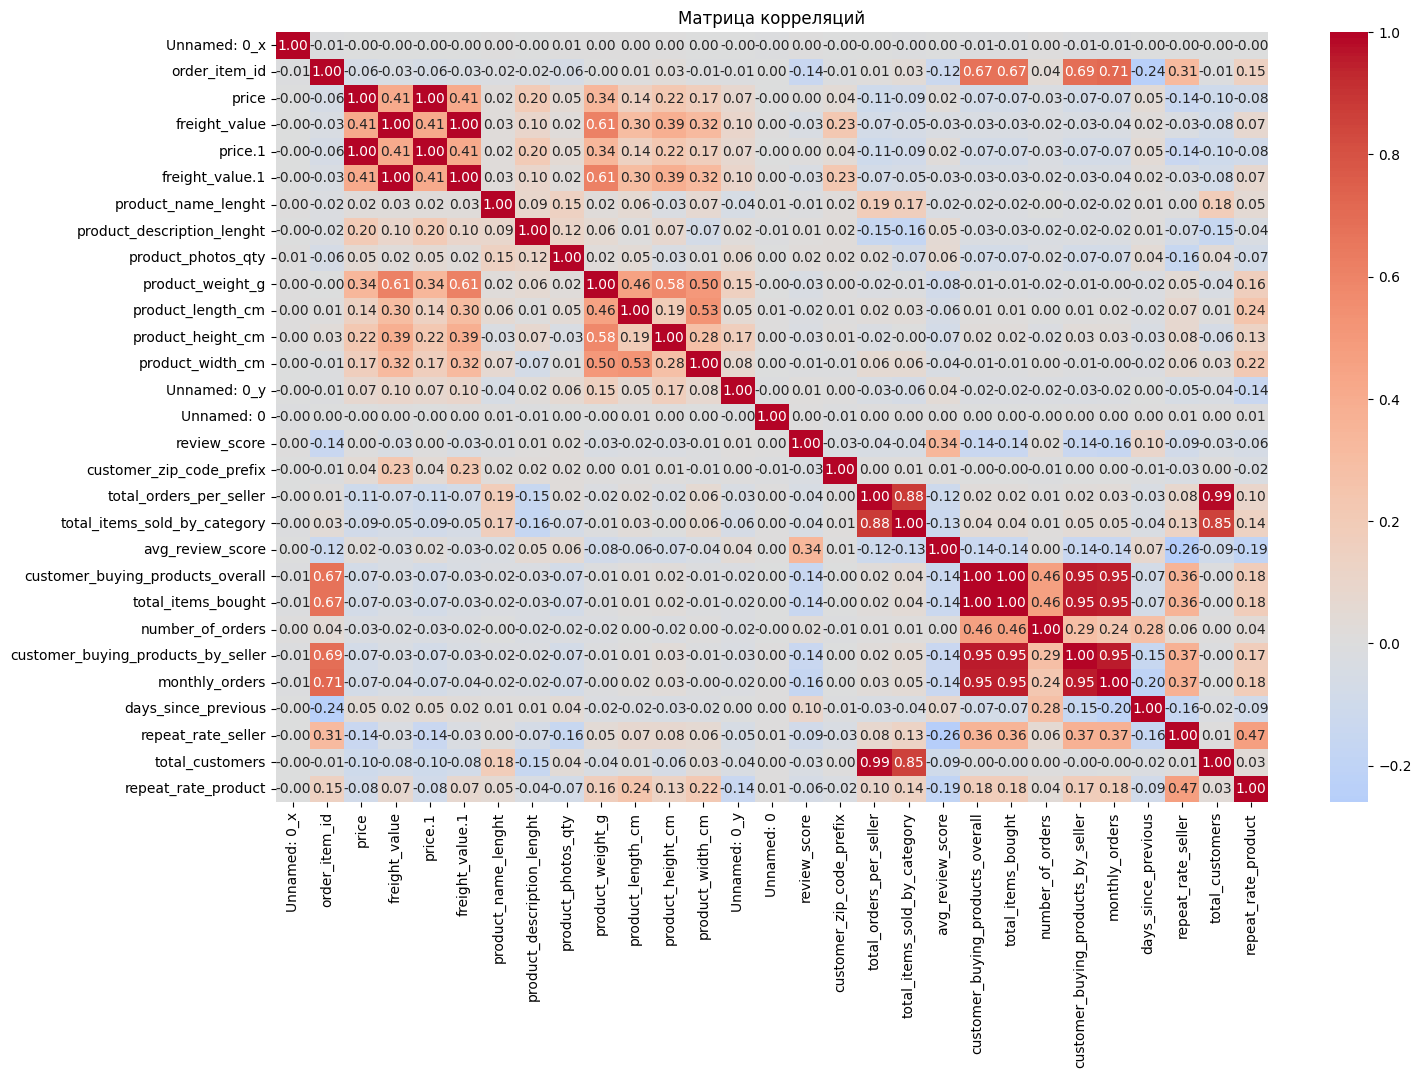

In [23]:
corr_matrix = dataset.corr(numeric_only = True)

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляций")
plt.show()